In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Data Preparation

In [3]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected.set_index('timestamp', inplace=True)
ss2_selected.index = pd.to_datetime(ss2_selected.index)
rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

In [4]:
selected_columns = [
        'mean_NW2_C02_rpm',
        'mean_NW2_C02_pitch', 
        'mean_NW2_C02_power',
        'mean_NW2_C02_windspeed',
        'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw',
        'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection',
        'mvbc_WandelaarBuoy_Wave_height',
        'mvbc_WandelaarBuoy_Average_wave_period',
        'mvbc_WandelaarMeasuringpile_Tide_TAW',
        #'mvbc_WandelaarMeasuringpile_Air_pressure',
        'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

In [5]:
from sklearn.linear_model import LinearRegression
from src.data.preprocessing import sin_cos_angle_inputs
selected_input_data_preprocessed = sin_cos_angle_inputs(rfe_selected_data.copy())[selected_columns]

lin_regr = LinearRegression()
X_lin_regr = selected_input_data_preprocessed.loc[ss2_selected['mean_frequency'].index]
X_lin_regr.dropna(inplace=True)
common_indices_lin = ss2_selected.index.intersection(X_lin_regr.index)
y_lin_regr = ss2_selected['mean_frequency'].loc[common_indices_lin]
X_lin_regr = X_lin_regr.loc[common_indices_lin]                  
lin_regr.fit(X_lin_regr, y_lin_regr)
ss2_predicted_lin_regr = pd.Series(
    lin_regr.predict(selected_input_data_preprocessed.dropna()),
    index=selected_input_data_preprocessed.dropna().index
    )
physical_mode = pd.DataFrame({
        'freq': ss2_predicted_lin_regr.copy()
    }, index=ss2_predicted_lin_regr.index)

In [161]:
def shift_data(data_, start_shift, end_shift, max_shift):
    """
    Progressively shift the data at index start_shift until end_shift and from 
    end_shift onwards, the data should be shifted by max_shift.

    Parameters:
    data (pd.Series or np.array): The dataset to be shifted.
    start_shift (int): The index at which to start shifting the data.
    end_shift (int): The index at which the maximum shift should start being applied.
    max_shift (int): The maximum shift to apply from end_shift onwards.

    Returns:
    pd.Series or np.array: The shifted dataset.
    """
    data = data_.copy()
    # Ensure data is a Series or an array for index operations
    if not isinstance(data, (pd.Series, np.ndarray)):
        raise ValueError("Data must be a Pandas Series or NumPy array.")

    # Initialize a new array for shifted data
    shifted_data = np.zeros_like(data)

    # Ensure valid indices
    if start_shift < 0 or end_shift >= len(data) or start_shift > end_shift:
        raise ValueError("Invalid start_shift or end_shift values.")

    # Calculate the shift increment
    shift_increment = max_shift / (end_shift - start_shift) if end_shift != start_shift else max_shift

    for i in range(len(data)):
        if i < start_shift:
            # No shift before start_shift
            shifted_data[i] = data.iloc[i] if isinstance(data, pd.Series) else data[i]
        elif start_shift <= i < end_shift:
            # Gradually increase the shift
            shift = shift_increment * (i - start_shift)
            shifted_data[i] = data.iloc[i] + shift if isinstance(data, pd.Series) else data[i] + shift
        else:
            # Apply max_shift
            shifted_data[i] = data.iloc[i] + max_shift if isinstance(data, pd.Series) else data[i] + max_shift

    return shifted_data if isinstance(data, np.ndarray) else pd.Series(shifted_data)

physical_mode_shifted = \
    pd.DataFrame({
        'freq': shift_data(physical_mode['freq'], int(len(physical_mode['freq'])*11.5/13), int(len(physical_mode['freq'])*12.9/13), -0.01)
    }).set_index(physical_mode.index)

In [162]:
def harmonic_generation(rpm:pd.Series, noise_level=0.1, p=6):
    """
    Generate a noisy dataset that is centered around a p multiple of the rpm.
    """
    harmonic_ = rpm * p
    harmonic = harmonic_ + np.random.normal(0, noise_level, len(harmonic_))
    return harmonic

harmonic_6p = harmonic_generation(rfe_selected_data[rfe_selected_data.filter(regex='rpm').columns[0]]/60, noise_level=0.02, p=6)

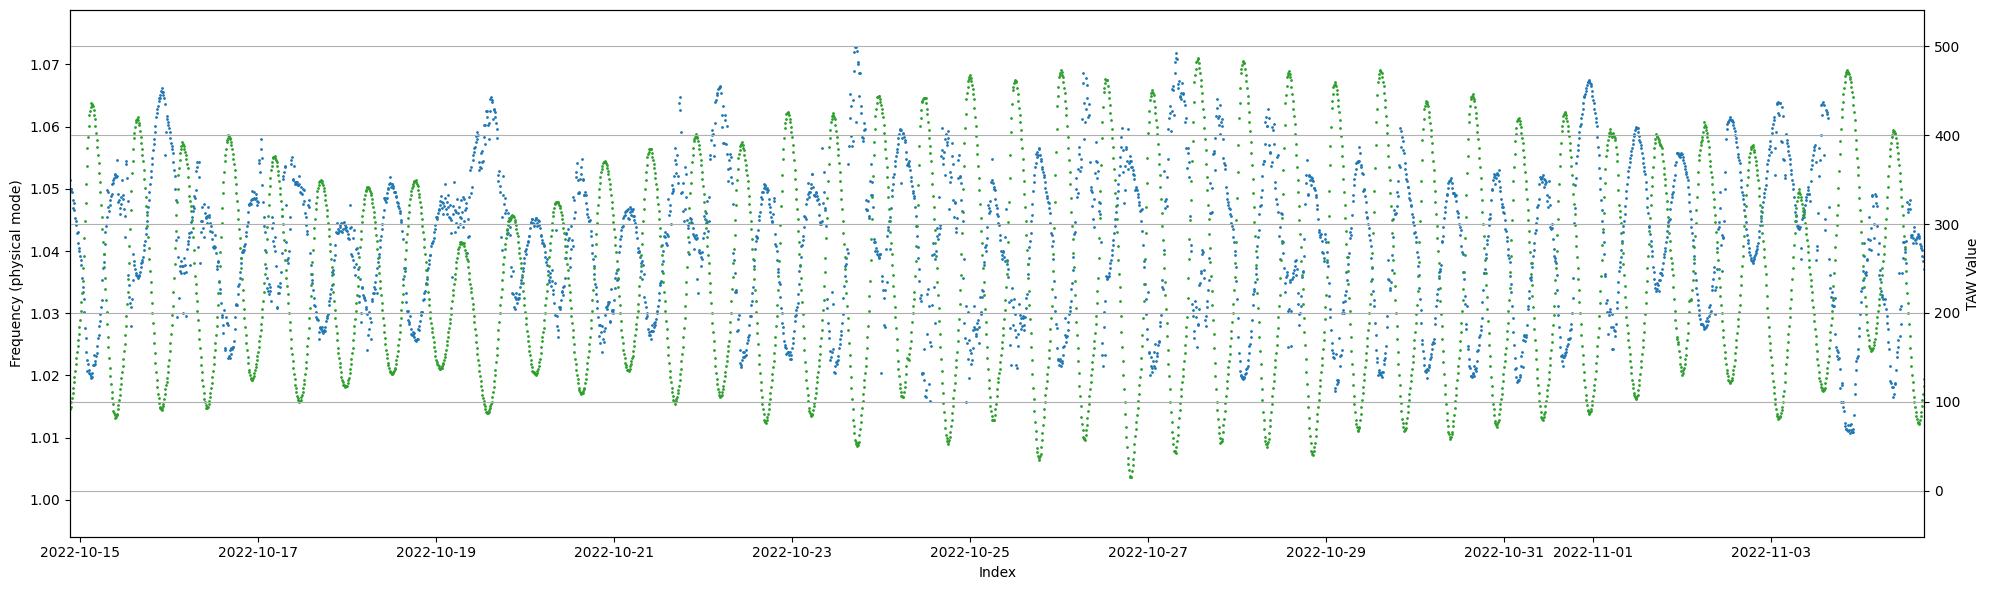

In [163]:
import matplotlib.pyplot as plt

# Assuming physical_mode and rfe_selected_data are your DataFrames

fig, ax1 = plt.subplots(figsize=(20, 6))

# Scatter plot for physical_mode
ax1.scatter(physical_mode.index, physical_mode['freq'], label='physical mode', s=1)
ax1.set_xlabel('Index')
ax1.set_ylabel('Frequency (physical mode)')
ax1.tick_params(axis='y')

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()
# Scatter plot for rfe_selected_data
ax2.scatter(rfe_selected_data.index, rfe_selected_data.filter(regex='TAW').iloc[:, 0],s=1,c='tab:green')  # Assuming you want the first column that matches the regex
ax2.set_ylabel('TAW Value')
ax2.tick_params(axis='y')

# Optionally, add a title and show the plot
fig.tight_layout()
plt.grid()
plt.xlim(rfe_selected_data.index[2000], rfe_selected_data.index[5000])
plt.show()

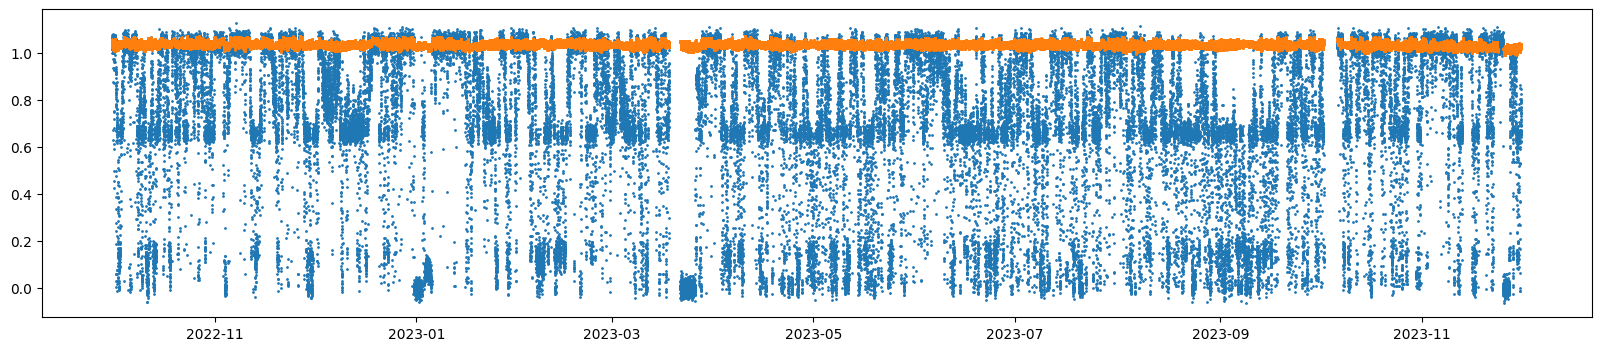

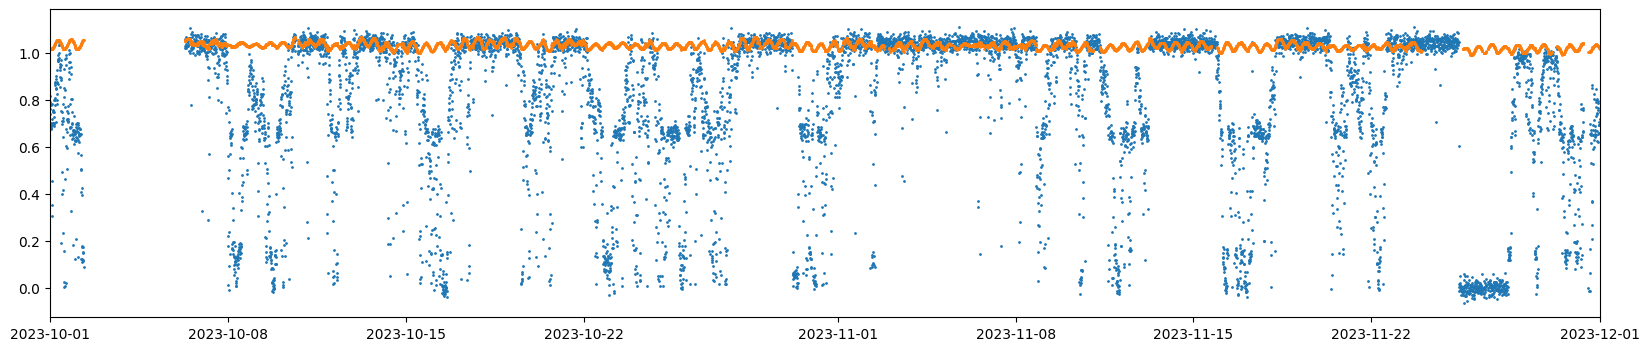

In [177]:
plt.figure(figsize=(20, 4))
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
#plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.show()
plt.figure(figsize=(20, 4))
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
#plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))
plt.show()

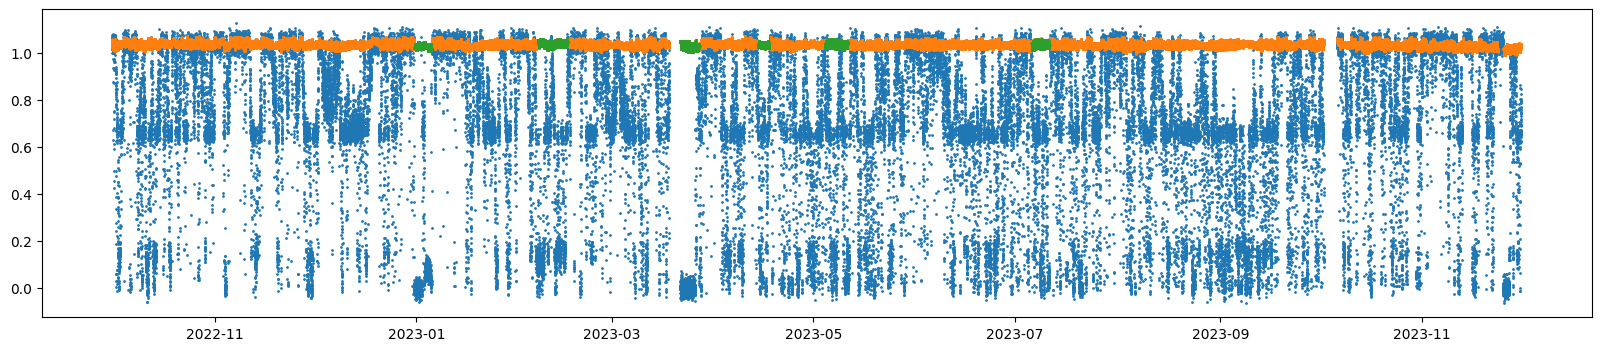

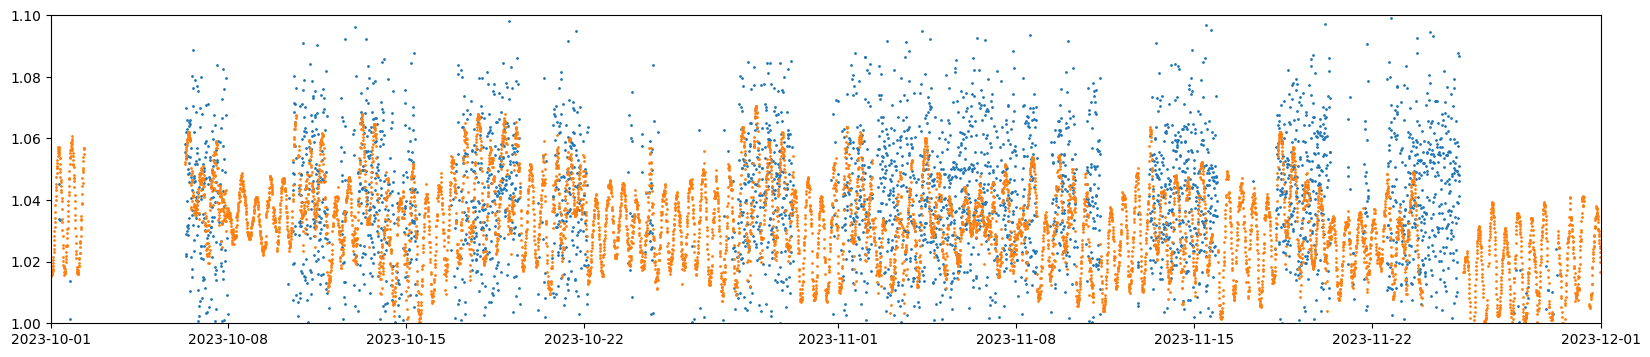

In [179]:
from src.data.preprocessing import sin_cos_angle_inputs
from sklearn.model_selection import train_test_split
X_ = rfe_selected_data.copy()
X = sin_cos_angle_inputs(X_)
X = X[selected_columns]
y = ss2_predicted_lin_regr.copy()
common_indices_Xy = X.index.intersection(y.index)
X = X.loc[common_indices_Xy]
y = y.loc[common_indices_Xy]

common_indices = X.dropna().index.intersection(ss2_selected.index)
common_indices = common_indices.intersection(y.index)
y_train = y.loc[common_indices]
X_train = X.loc[common_indices]
y_train = y_train.loc[common_indices]

plt.figure(figsize=(20, 4))
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
#plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.scatter(y_train.index, y_train, s=1)
plt.show()

plt.figure(figsize=(20, 4))
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
#plt.scatter(physical_mode.index, physical_mode, s=1)
plt.scatter(physical_mode.index, physical_mode_shifted, s=1)
plt.scatter(y_train.index, y_train, s=1)
plt.ylim(1.0, 1.1)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))
plt.show()

# Train the model

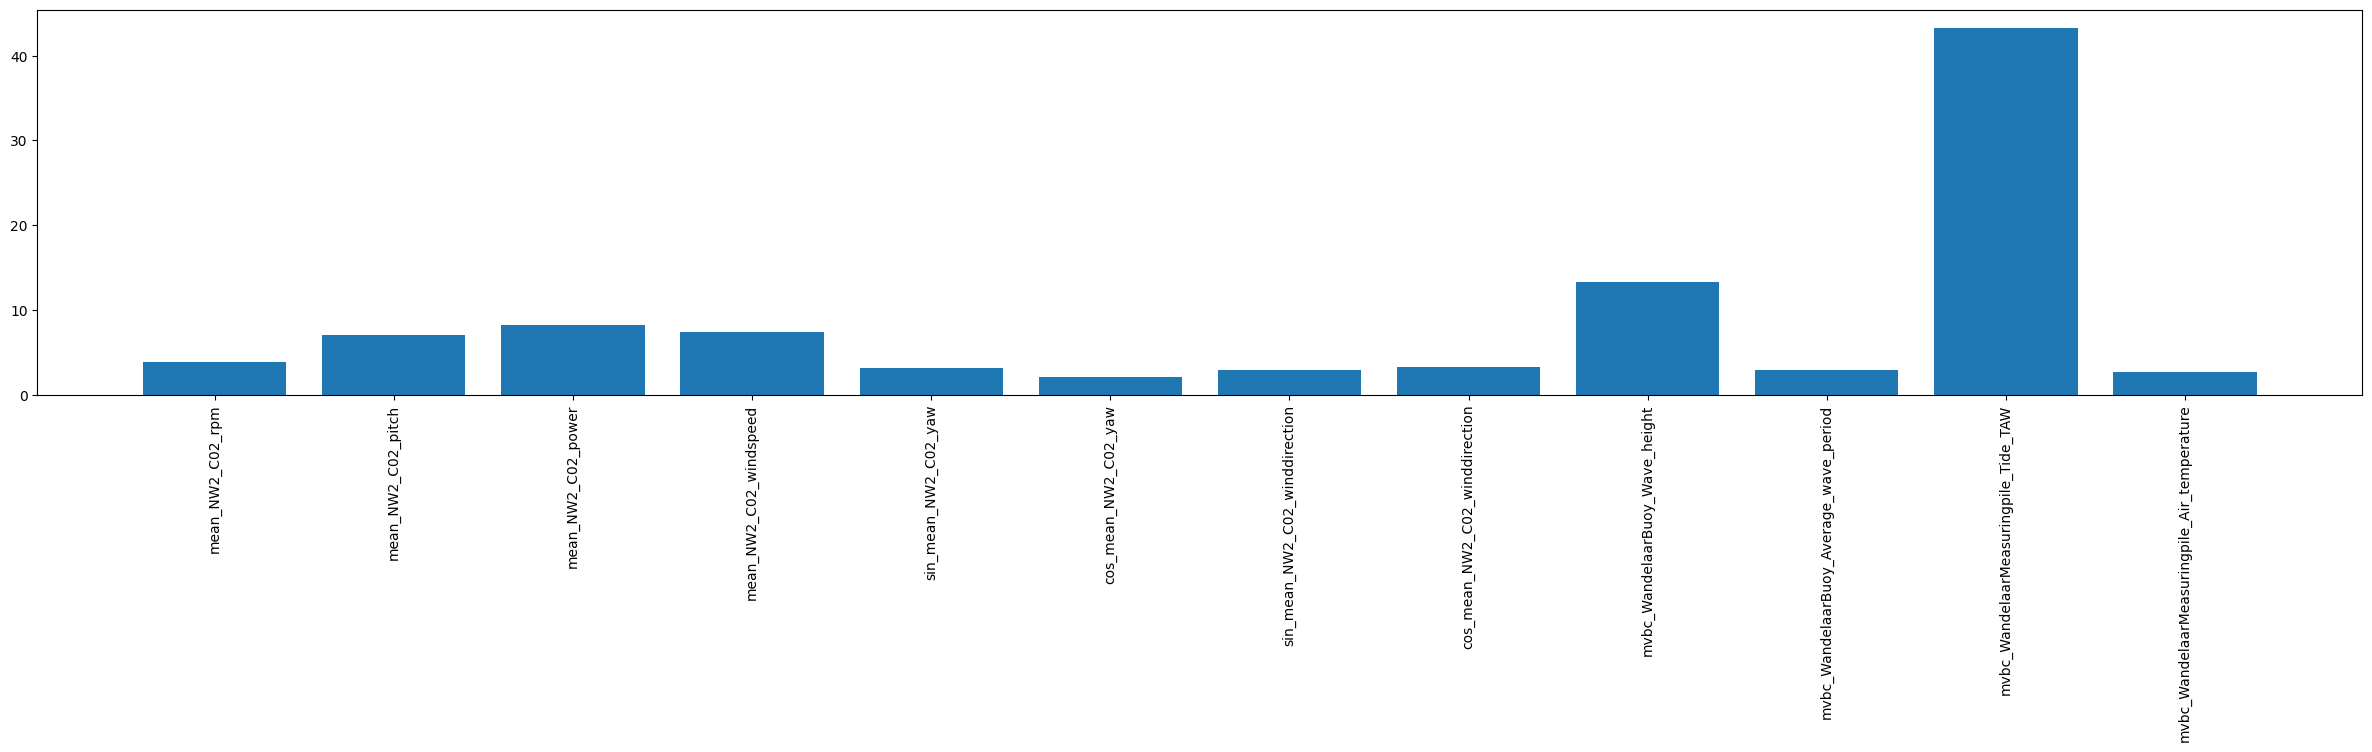

In [166]:
from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()

# Make predictions and uncertainty + smart track

In [167]:
import pandas as pd
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)

predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=100, ntree_end=500) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

uncertainty_lim = uncertainty_.loc[X_train.index].quantile(0.7)
prediction_lim = (y_train - predictions_df['prediction'].loc[X_train.dropna().index]).std()*30
prediction_lim = (y - predictions_df['prediction']).std()*5

# Smart tracking
from src.smart_tracking.smart_tracking import *

smart_tracked_modes = smart_tracking(
    physical_mode['freq'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )

In [168]:
prediction_lim

0.02160239180429333

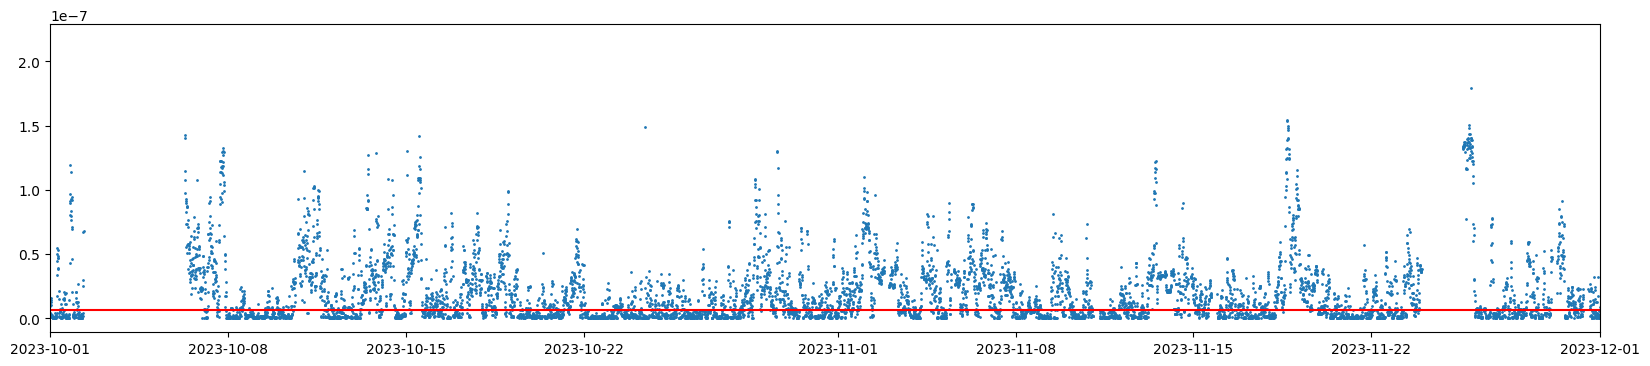

(19631.0, 19692.0)

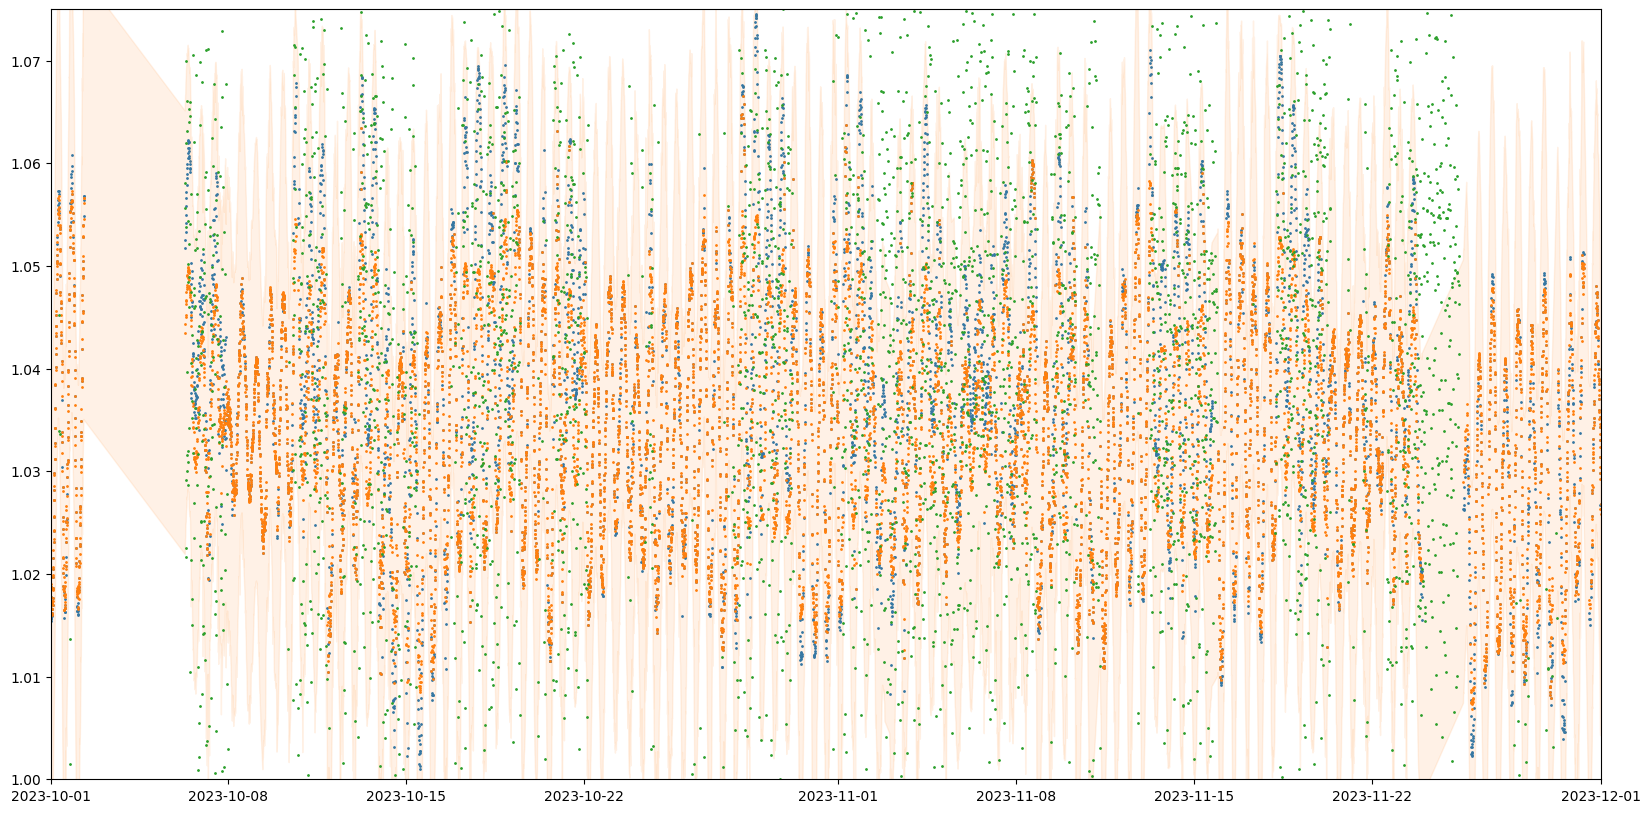

In [169]:
plt.figure(figsize=(20, 4))
plt.scatter(uncertainty_.index, uncertainty_, s=1)
#plt.scatter(uncertainty_moving_avg.index, uncertainty_moving_avg, s=1)
plt.hlines(uncertainty_lim, uncertainty_moving_avg.index[0], uncertainty_moving_avg.index[-1], color='r')
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))
plt.show()
plt.figure(figsize=(20, 10))
plt.scatter(physical_mode.index, physical_mode['freq'], s=1)
plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, c='tab:orange')
plt.fill_between(predictions_df.index, predictions_df['prediction']-prediction_lim, predictions_df['prediction']+prediction_lim, color='tab:orange', alpha=0.1)
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['freq'], s=1)
plt.scatter(harmonic_6p.index, harmonic_6p, s=1)
plt.ylim(1,1.075)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))

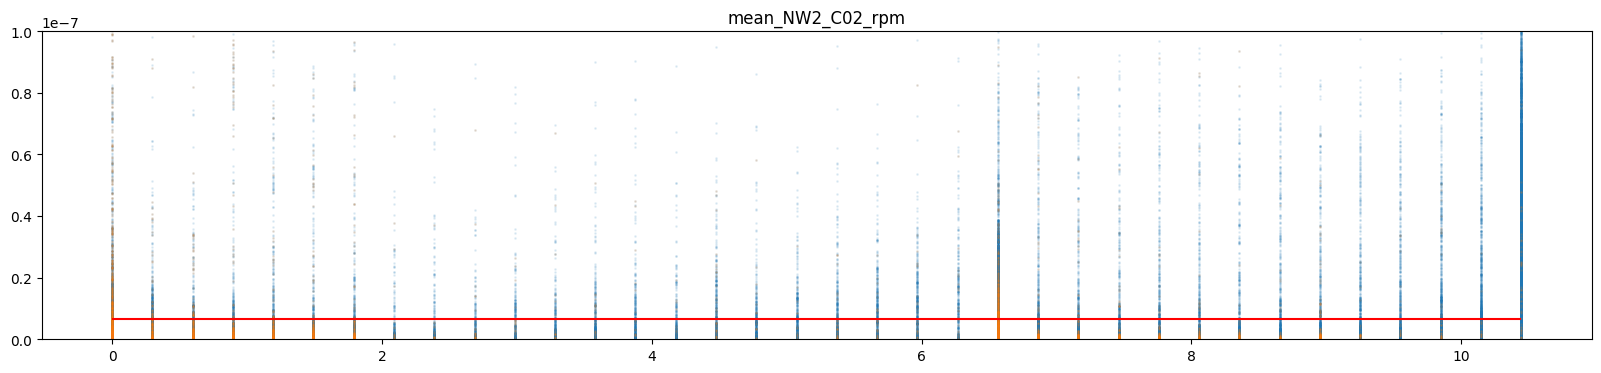

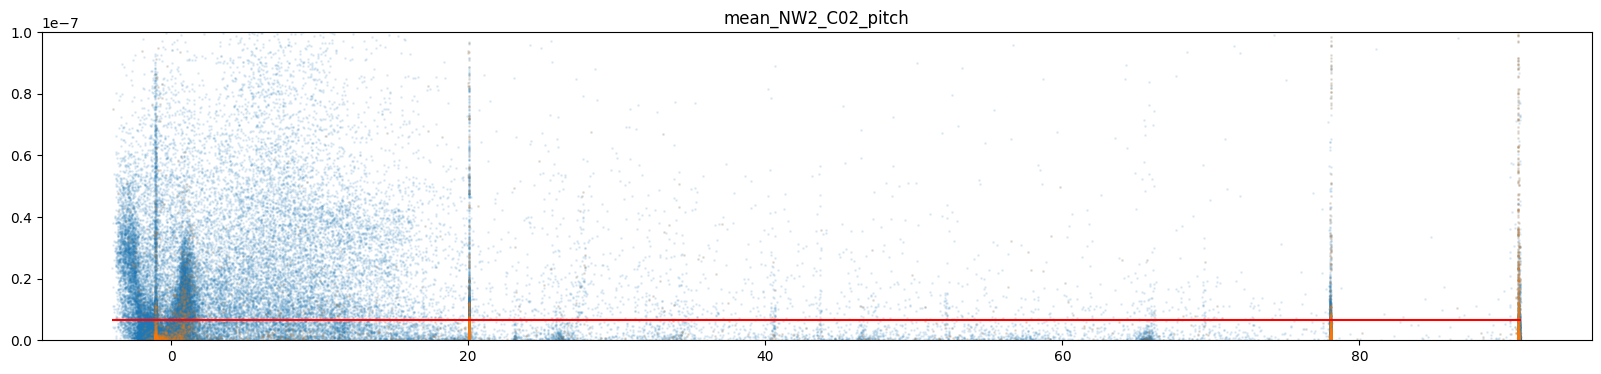

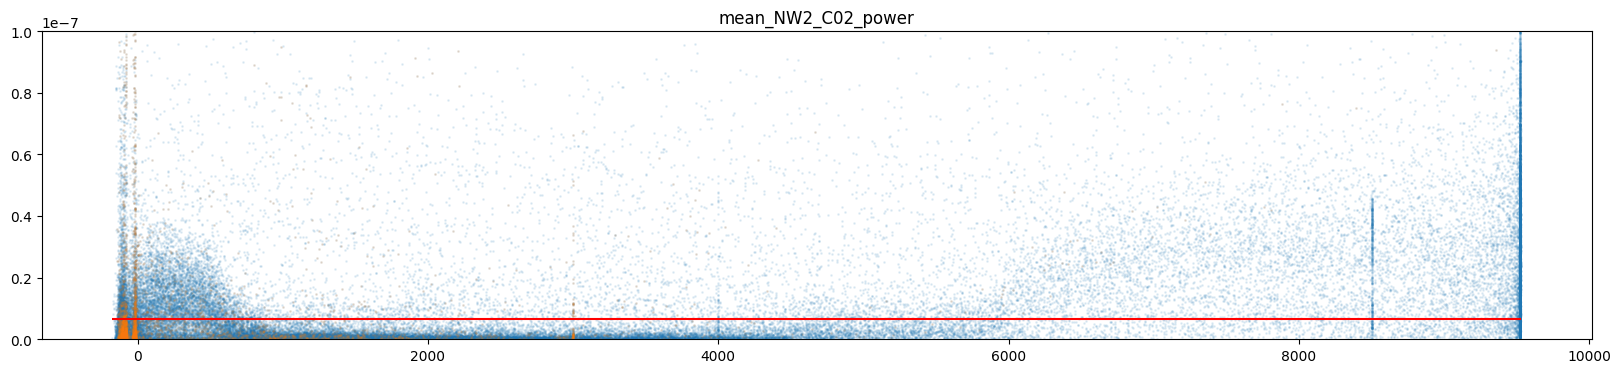

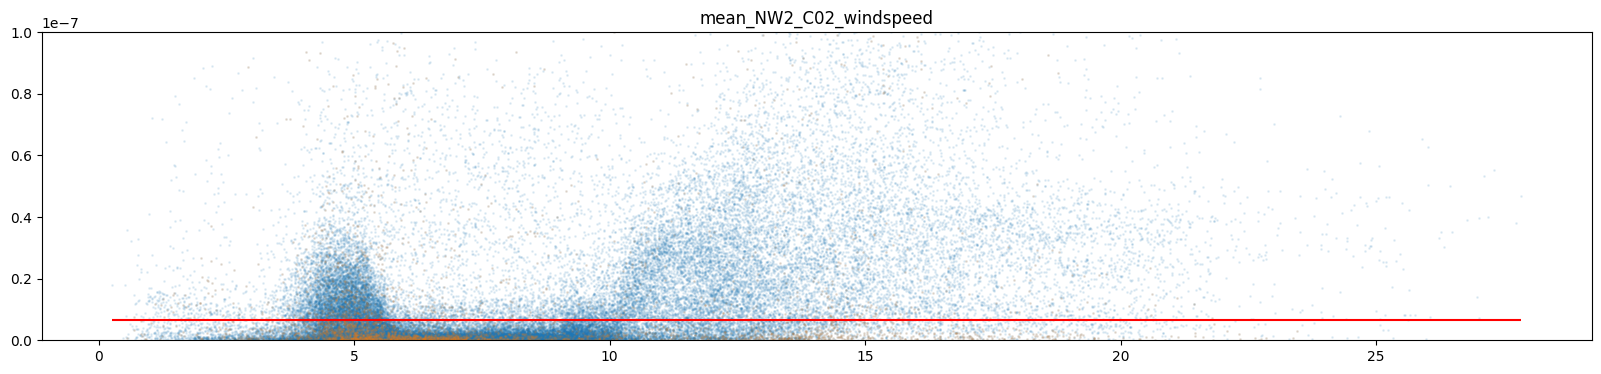

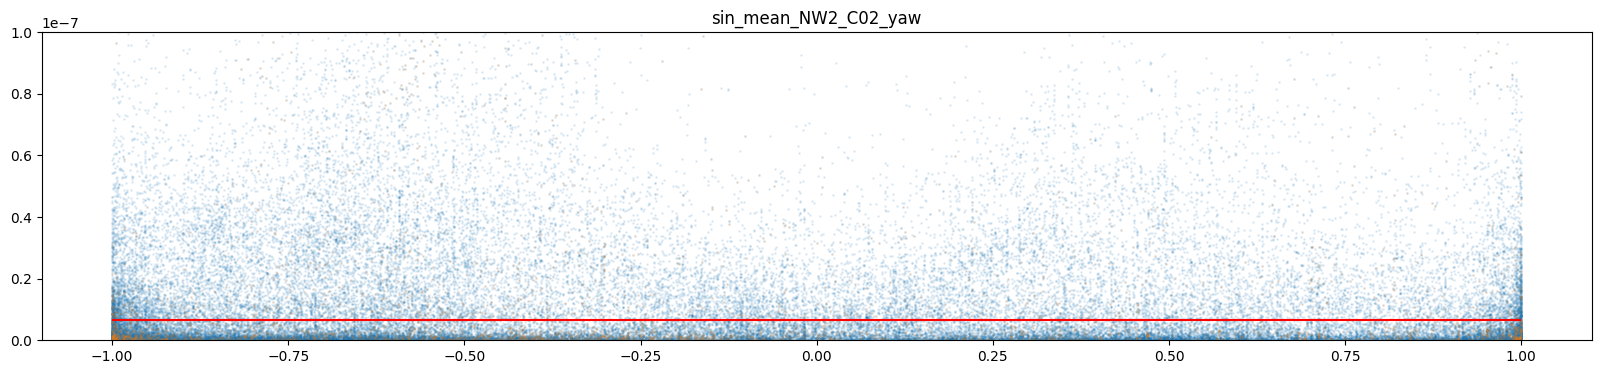

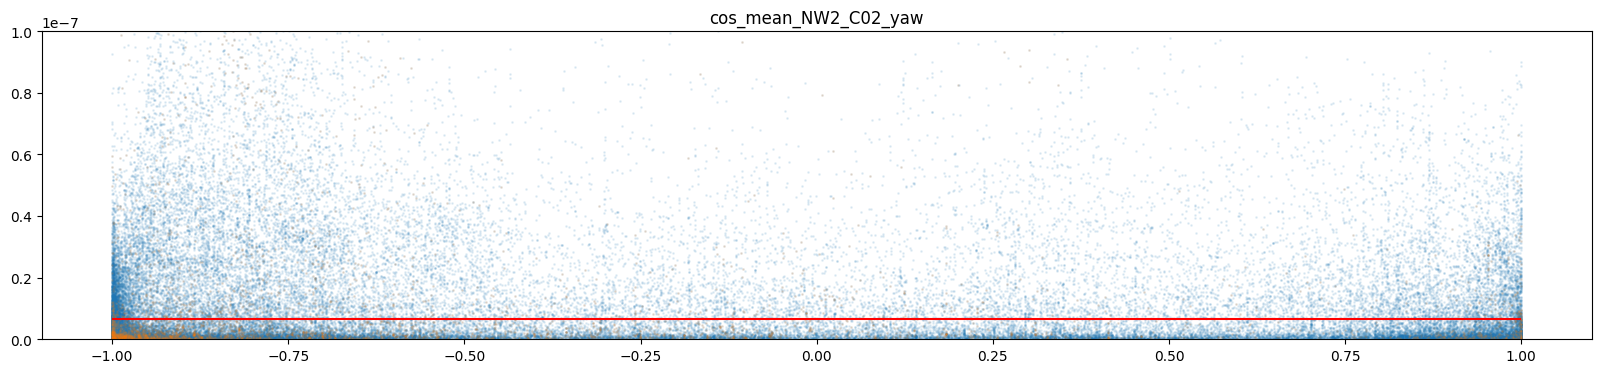

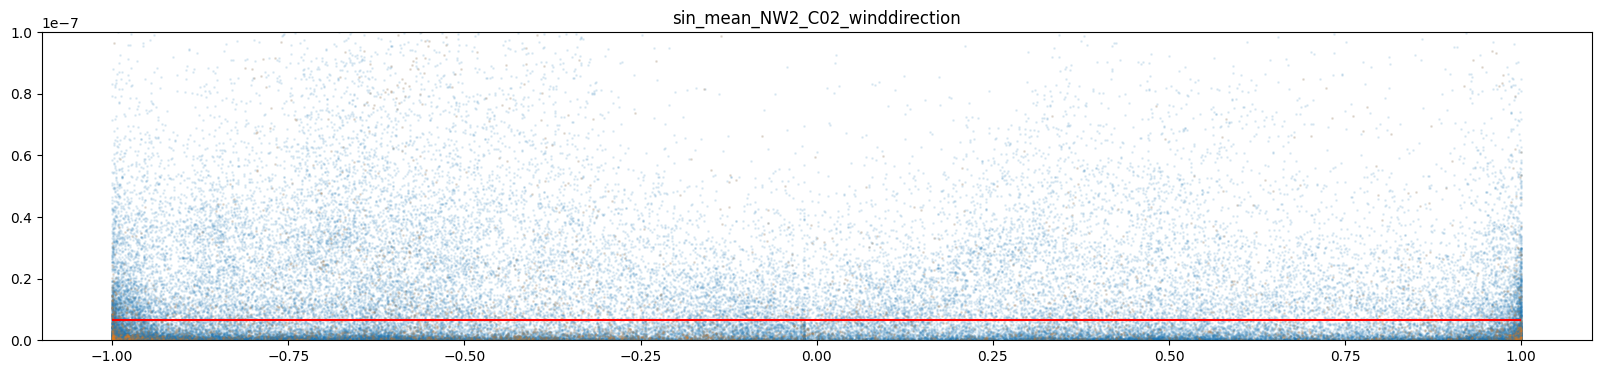

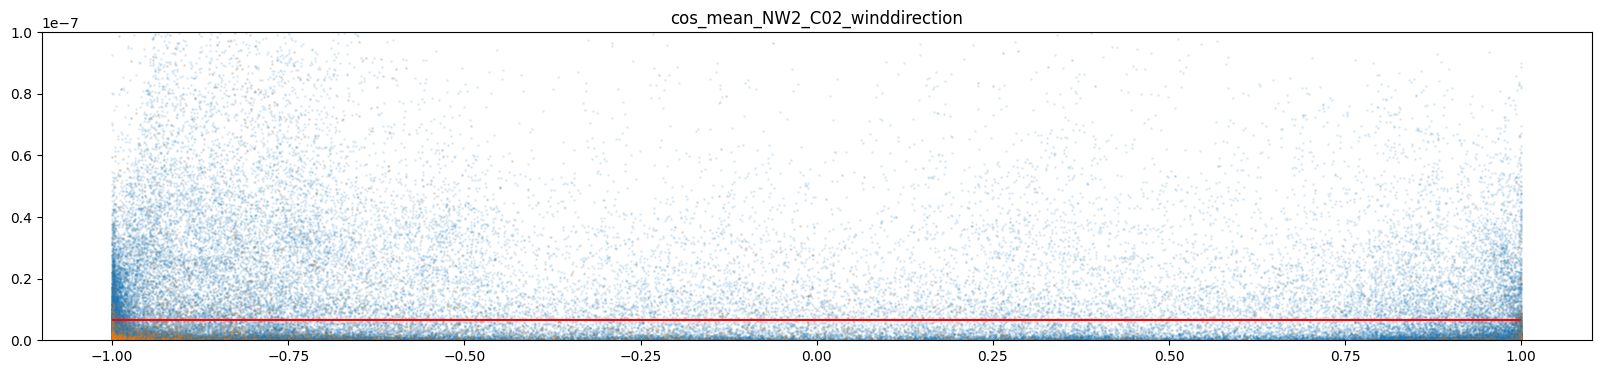

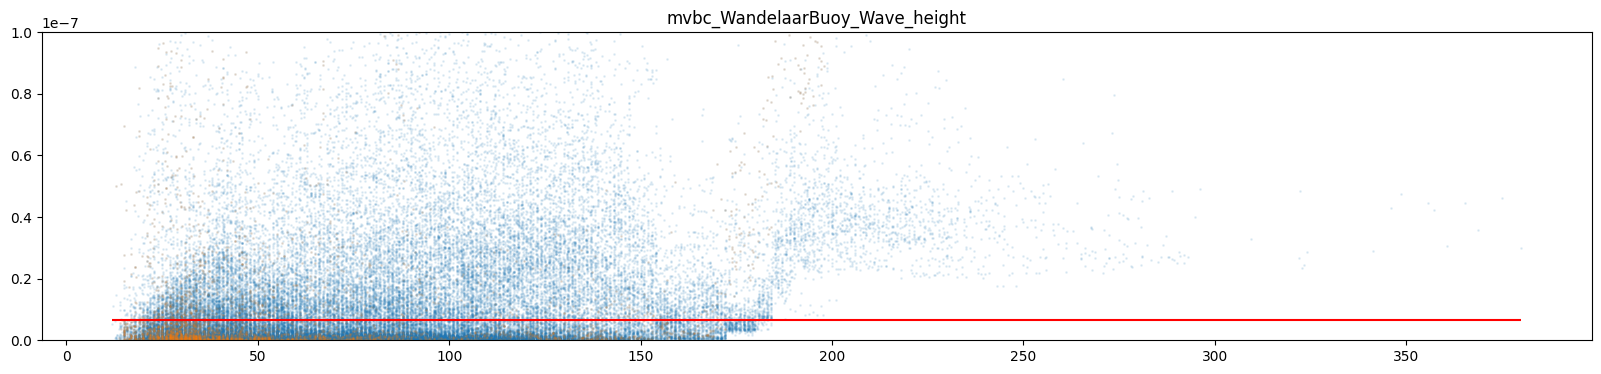

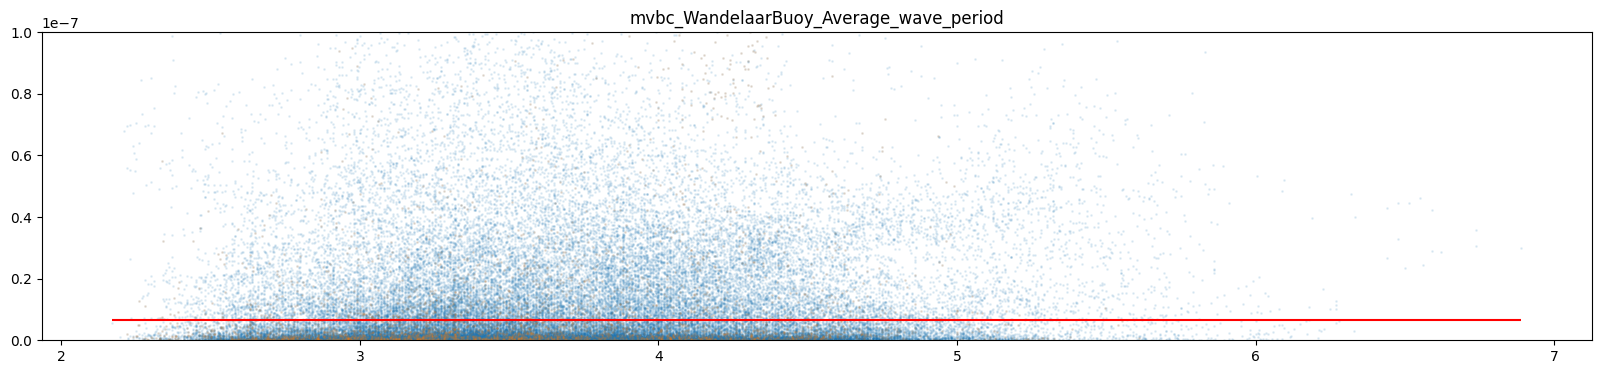

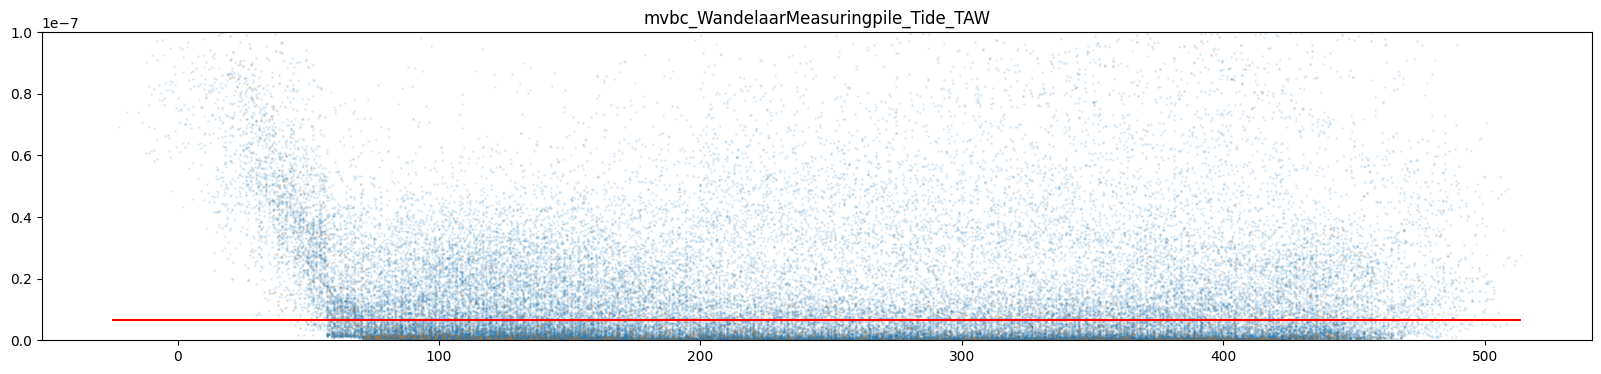

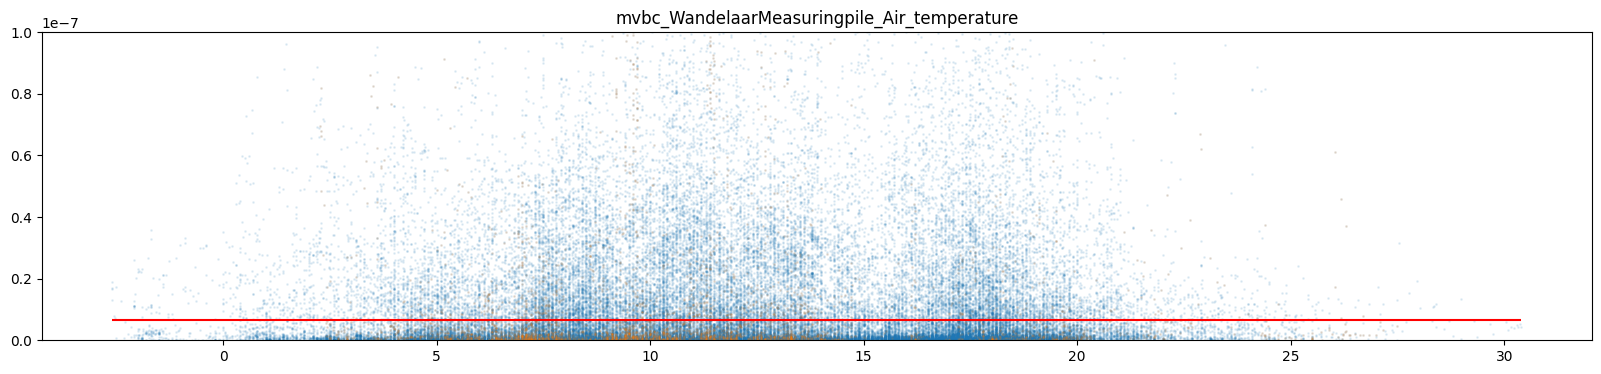

In [170]:
for col in X.columns:
    plt.figure(figsize=(20, 4))
    plt.scatter(X[col],knowledge_uncertainty, s=1, alpha=0.1)
    plt.scatter(X_train[col],predictions_df['knowledge_uncertainty'].loc[X_train.index], s=1, alpha=0.1)
    plt.hlines(uncertainty_lim, np.min(X[col]), np.max(X[col]), color='r')
    plt.ylim(0,1e-7)
    plt.title(col)
    plt.show()

In [171]:
harmonic_6p_input = pd.DataFrame({
    'freq':harmonic_6p},
    index=harmonic_6p.index
    )

differences = pd.DataFrame({'diff':(harmonic_6p_input-physical_mode_shifted).values[:,0]},index=harmonic_6p_input.index)
small_differences = differences[np.abs(differences['diff'])<0.2]

In [172]:
all_inputs = pd.concat([physical_mode_shifted[~physical_mode_shifted.index.isin(small_differences.index)], harmonic_6p_input], axis=0)
all_inputs.sort_index(inplace=True)
all_inputs_final = all_inputs

In [173]:
# all_inputs = pd.concat([physical_mode_shifted, harmonic_6p_input], axis=0)
# all_inputs.sort_index(inplace=True)
# #remove dumplicate index and keep first
# all_inputs_small_diff = all_inputs.loc[small_differences.index]
# all_inputs_big_diff = all_inputs.loc[~all_inputs.index.isin(small_differences.index)]
# all_inputs_small_diff = all_inputs_small_diff[~all_inputs_small_diff.index.duplicated(keep='first')]
# all_inputs_final = pd.concat([all_inputs_small_diff, all_inputs_big_diff], axis=0)
# all_inputs_final = 

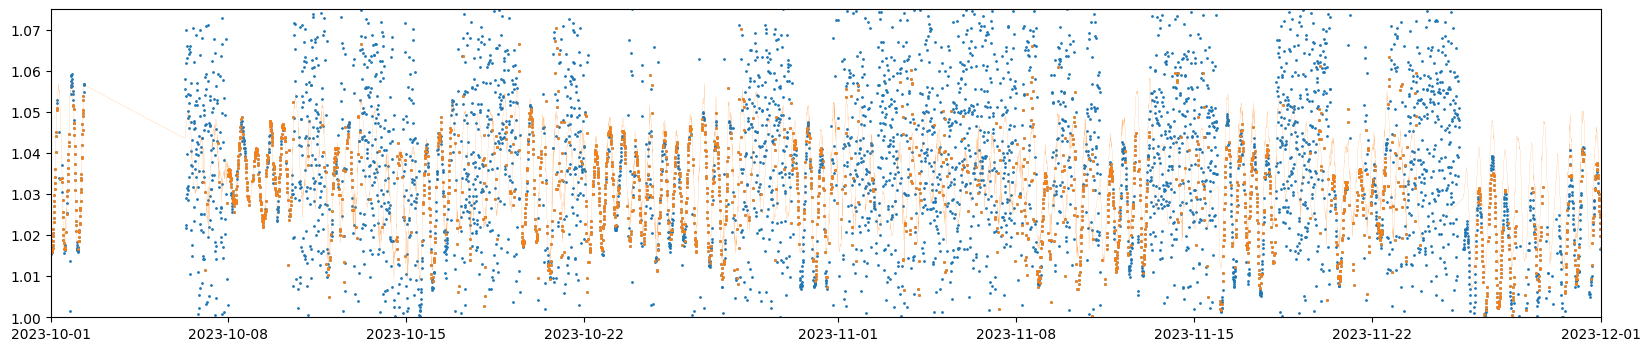

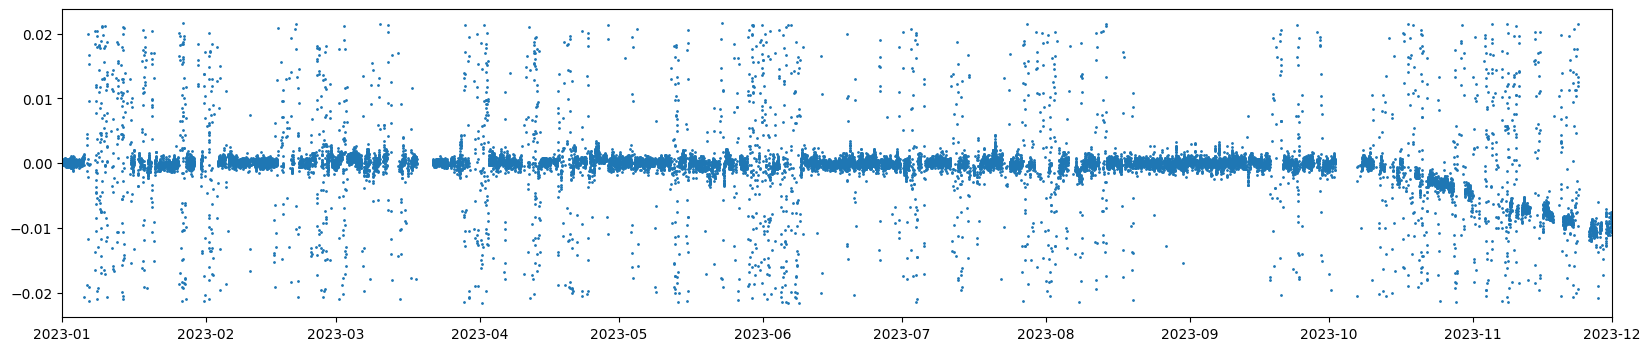

In [174]:


smart_tracked = smart_tracking(
    all_inputs_final['freq'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )

plt.figure(figsize=(20, 4))
plt.scatter(all_inputs.index, all_inputs['freq'], s=1)
plt.scatter(smart_tracked.index, smart_tracked['freq'], s=1)
plt.plot(predictions_df.index, predictions_df['prediction'], c='tab:orange', linewidth=0.1)
plt.ylim(0.95,1.12)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))
plt.ylim(1,1.075)
plt.show()

residual = smart_tracked['freq'] - predictions_df['prediction']
residual_smart_tracked = residual.loc[smart_tracked.index]
plt.figure(figsize=(20, 4))
plt.scatter(residual_smart_tracked.index, residual_smart_tracked, s=1)
plt.xlim(datetime.datetime(2023,1,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))

plt.show()

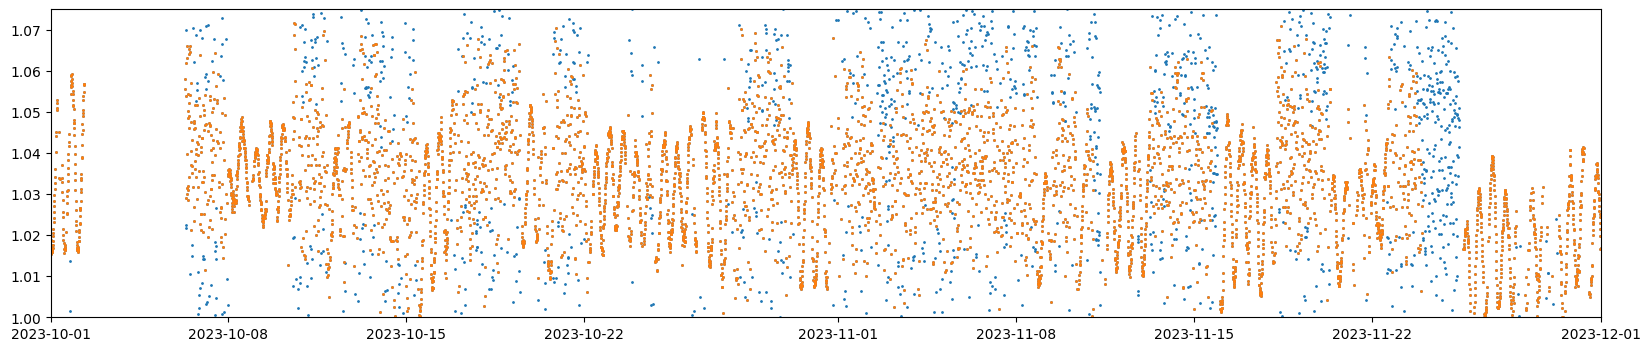

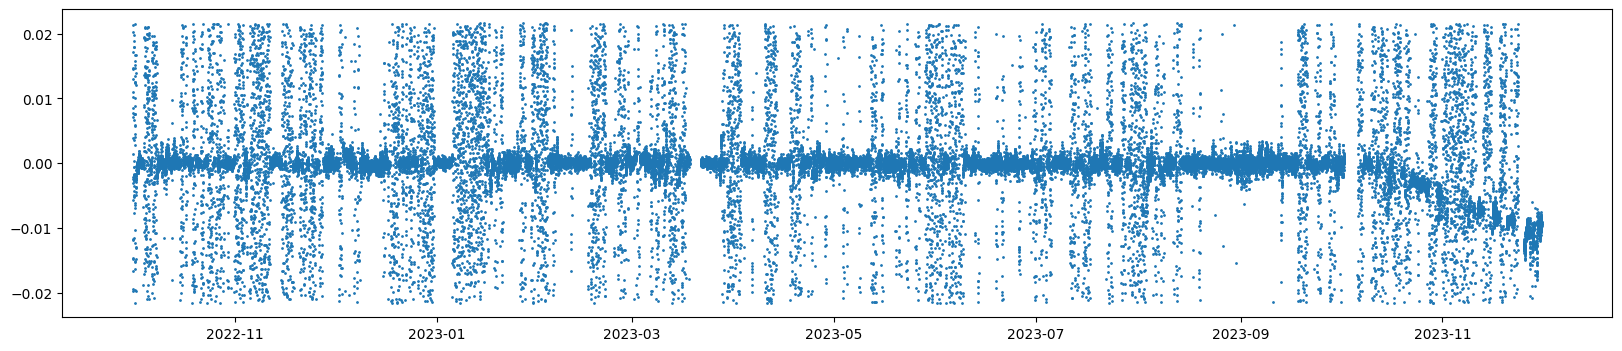

In [175]:
model_based_tracked = smart_tracking(
    all_inputs_final['freq'],
    predictions_df['prediction'],
    uncertainty_,
    10,
    prediction_lim
    )
residual = model_based_tracked['freq'] - predictions_df['prediction']
residual_model_based_tracked = residual.loc[model_based_tracked.index]
plt.figure(figsize=(20, 4))
plt.scatter(all_inputs.index, all_inputs['freq'], s=1)
plt.scatter(model_based_tracked.index, model_based_tracked['freq'], s=1)
plt.ylim(0.95,1.12)
plt.xlim(datetime.datetime(2023,10,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))
plt.ylim(1,1.075)
plt.show()
plt.figure(figsize=(20, 4))
plt.scatter(residual_model_based_tracked.index, residual_model_based_tracked, s=1)
#plt.xlim(datetime.datetime(2023,1,1, tzinfo=datetime.timezone.utc), datetime.datetime(2023,12,1, tzinfo=datetime.timezone.utc))

plt.show()

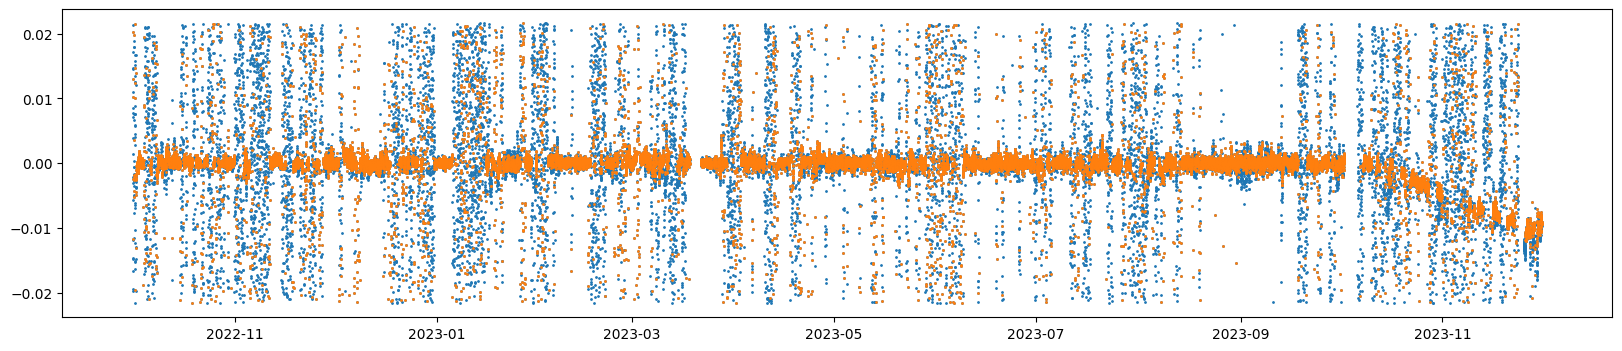

In [176]:
plt.figure(figsize=(20, 4))
plt.scatter(residual_model_based_tracked.index, residual_model_based_tracked, s=1)
plt.scatter(residual_smart_tracked.index, residual_smart_tracked, s=1)
plt.show()

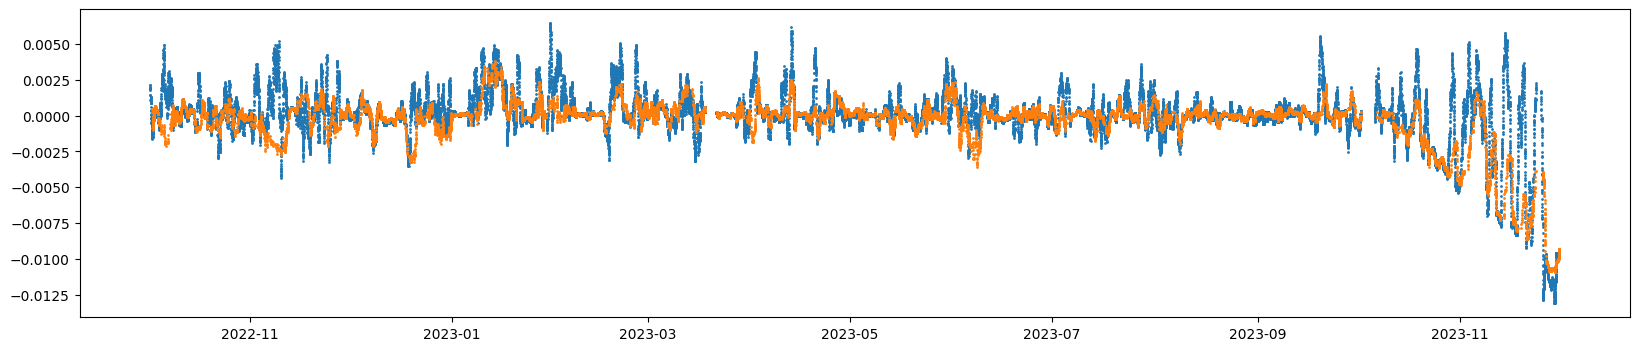

In [182]:
plt.figure(figsize=(20, 4))
plt.scatter(residual_model_based_tracked.dropna().rolling(12*6).mean().index, residual_model_based_tracked.dropna().rolling(12*6).mean(), s=1)
plt.scatter(residual_smart_tracked.dropna().rolling(12*6).mean().index, residual_smart_tracked.dropna().rolling(12*6).mean(), s=1)
plt.show()

In [186]:
year=2023
residual_smart_tracked[residual_smart_tracked.index.year==year].index

DatetimeIndex(['2023-01-01 00:00:00+00:00', '2023-01-01 00:10:00+00:00',
               '2023-01-01 00:20:00+00:00', '2023-01-01 00:30:00+00:00',
               '2023-01-01 00:40:00+00:00', '2023-01-01 00:50:00+00:00',
               '2023-01-01 01:00:00+00:00', '2023-01-01 01:10:00+00:00',
               '2023-01-01 01:20:00+00:00', '2023-01-01 01:30:00+00:00',
               ...
               '2023-11-30 22:20:00+00:00', '2023-11-30 22:30:00+00:00',
               '2023-11-30 22:40:00+00:00', '2023-11-30 22:50:00+00:00',
               '2023-11-30 23:00:00+00:00', '2023-11-30 23:10:00+00:00',
               '2023-11-30 23:20:00+00:00', '2023-11-30 23:30:00+00:00',
               '2023-11-30 23:40:00+00:00', '2023-12-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=19430, freq=None)

In [192]:
residual_model_based_tracked_year.loc[residual_model_based_tracked_year.index.month==11]

2023-11-01 03:00:00+00:00    0.001382
2023-11-01 03:40:00+00:00    0.002417
2023-11-01 06:20:00+00:00   -0.014715
2023-11-01 06:30:00+00:00   -0.018323
2023-11-01 06:40:00+00:00   -0.015242
                               ...   
2023-11-30 23:00:00+00:00   -0.009346
2023-11-30 23:10:00+00:00   -0.009323
2023-11-30 23:20:00+00:00   -0.009337
2023-11-30 23:30:00+00:00   -0.008994
2023-11-30 23:40:00+00:00   -0.009426
Length: 1102, dtype: float64

2022 10


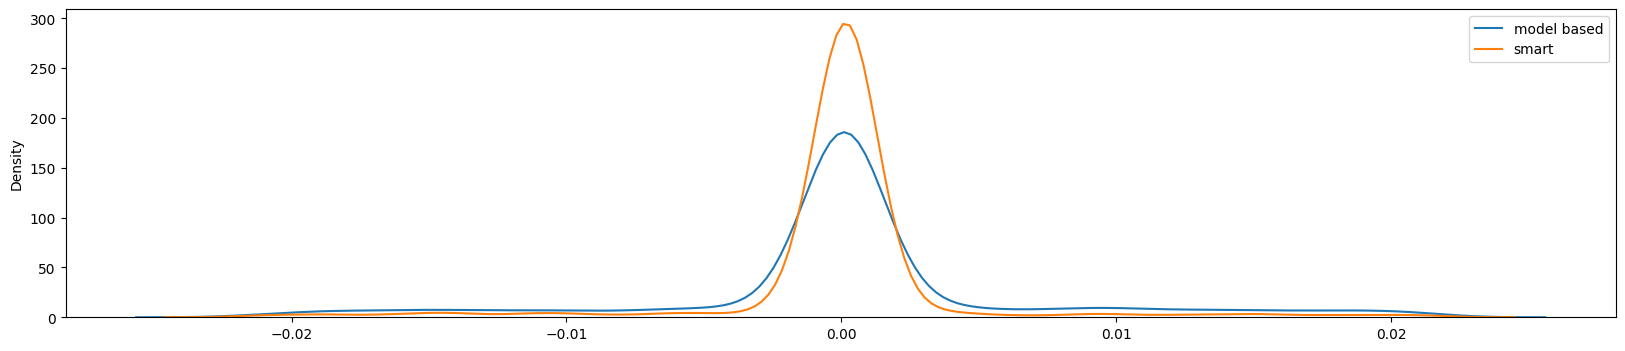

2022 11


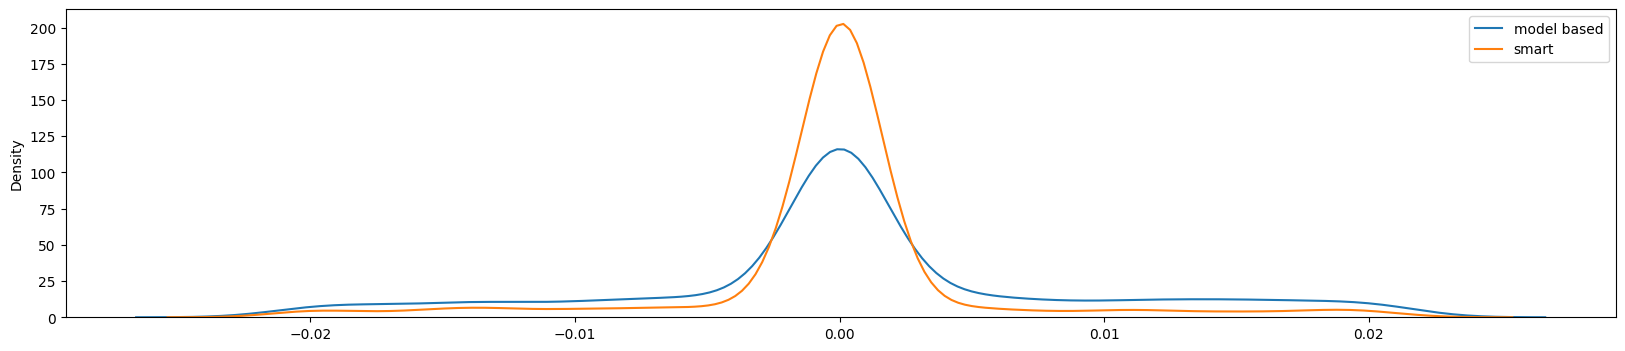

2022 12


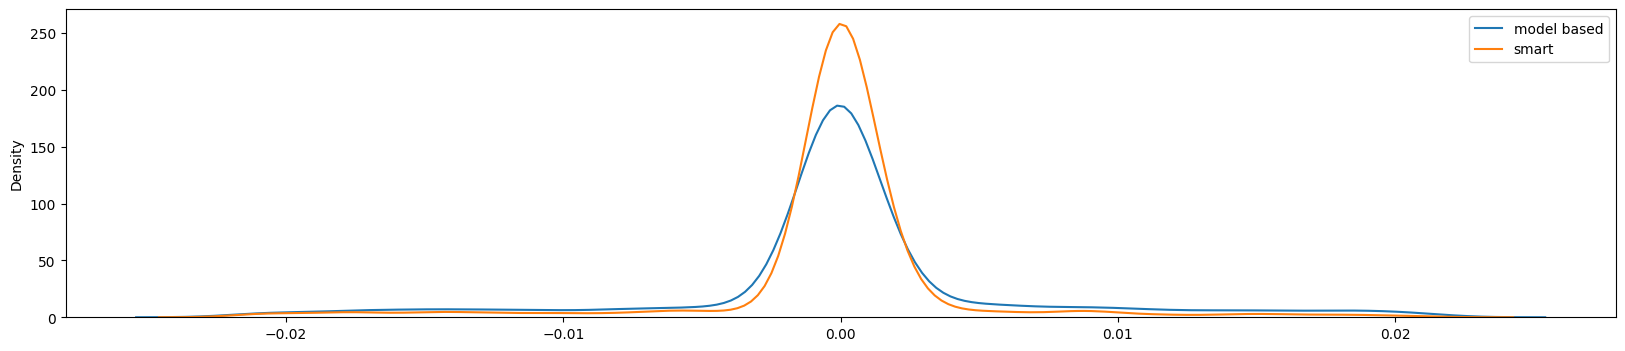

2023 1


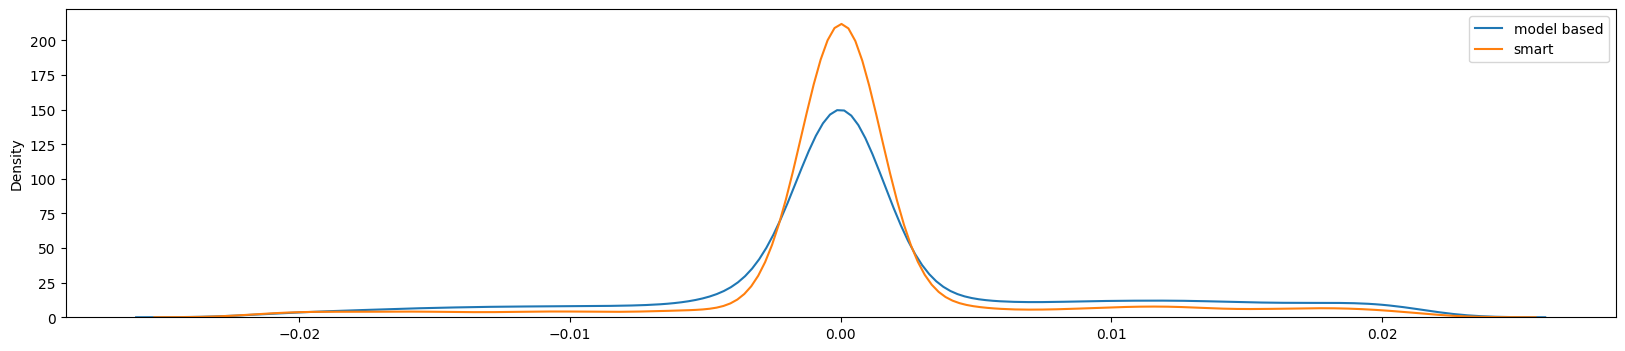

2023 2


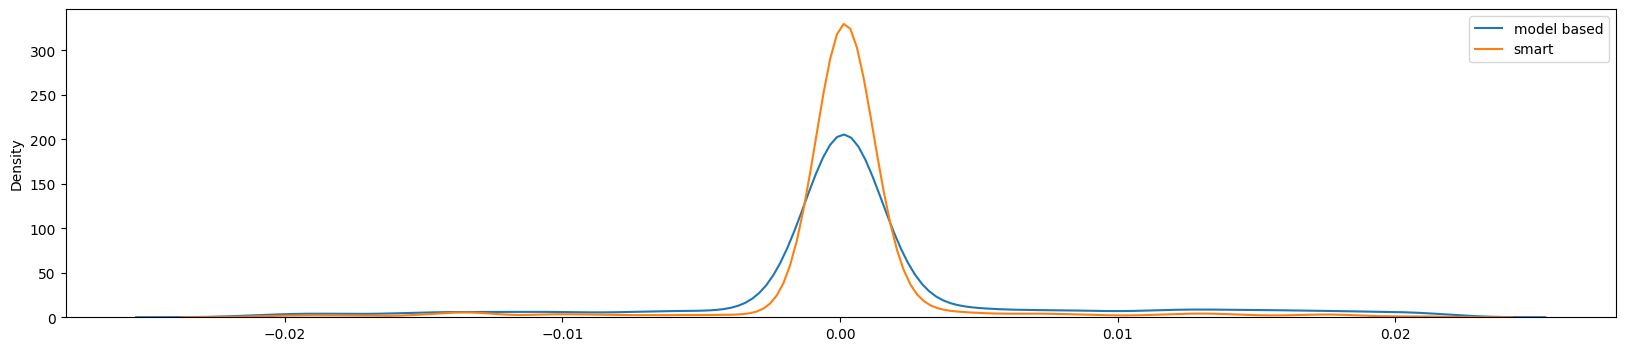

2023 3


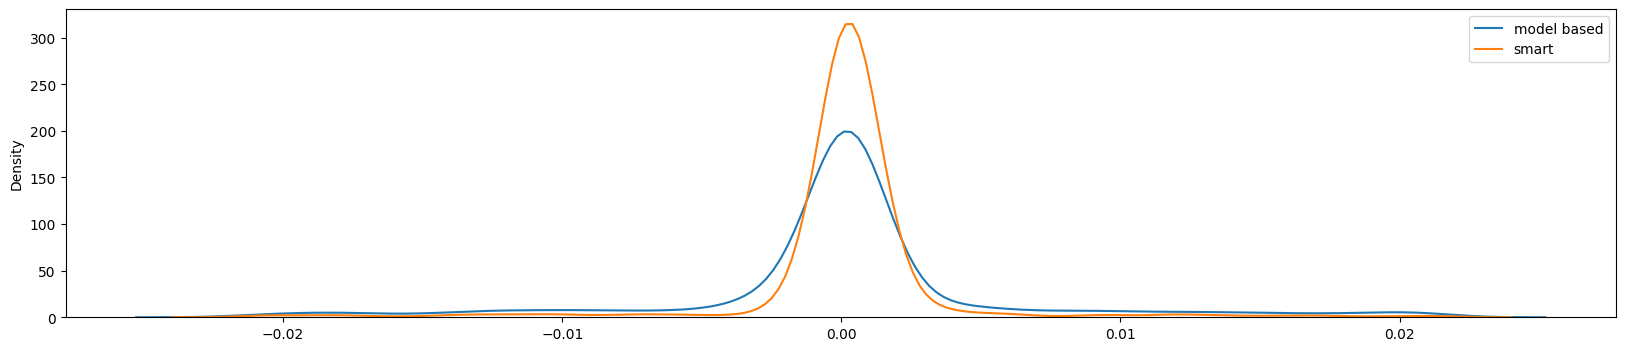

2023 4


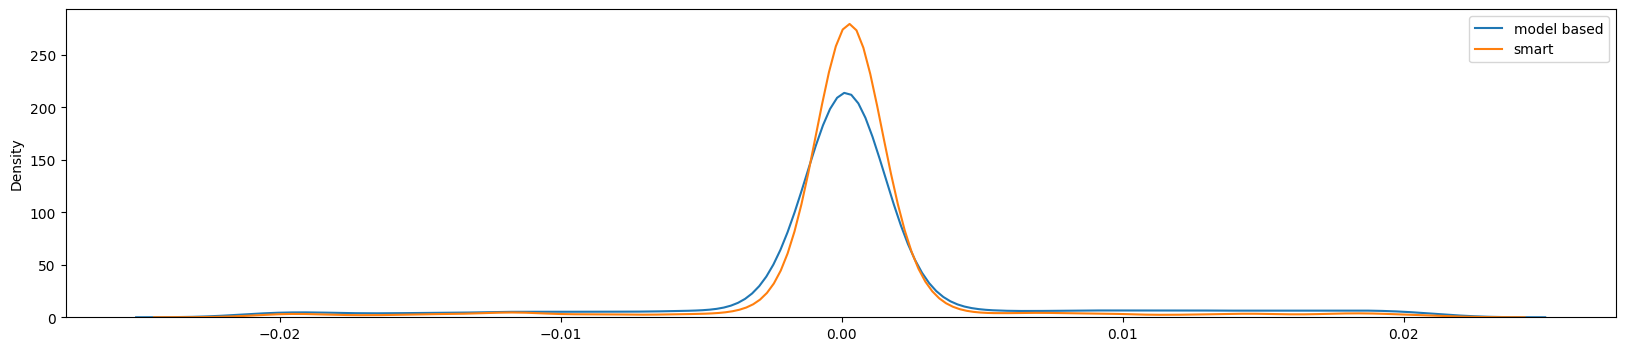

2023 5


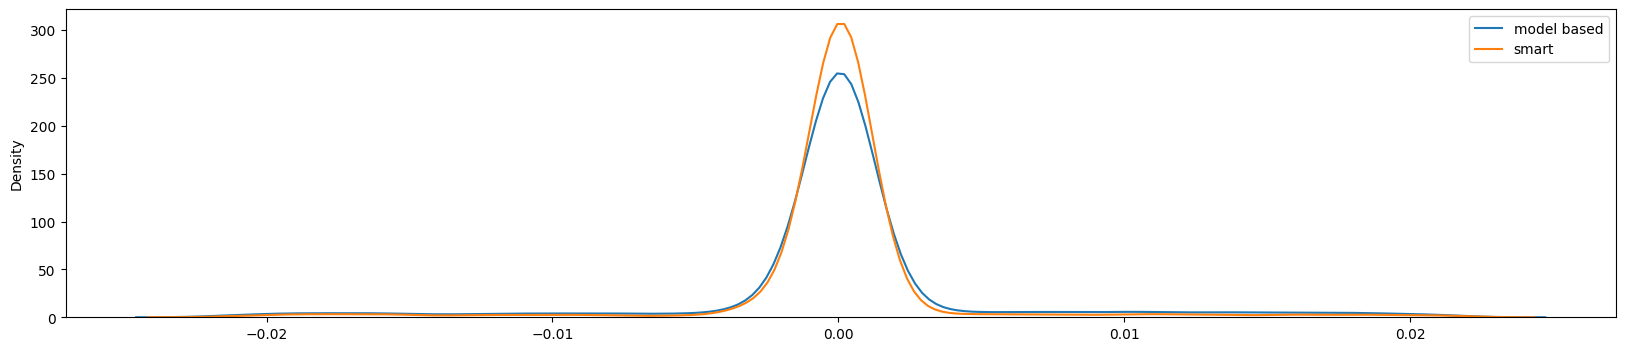

2023 6


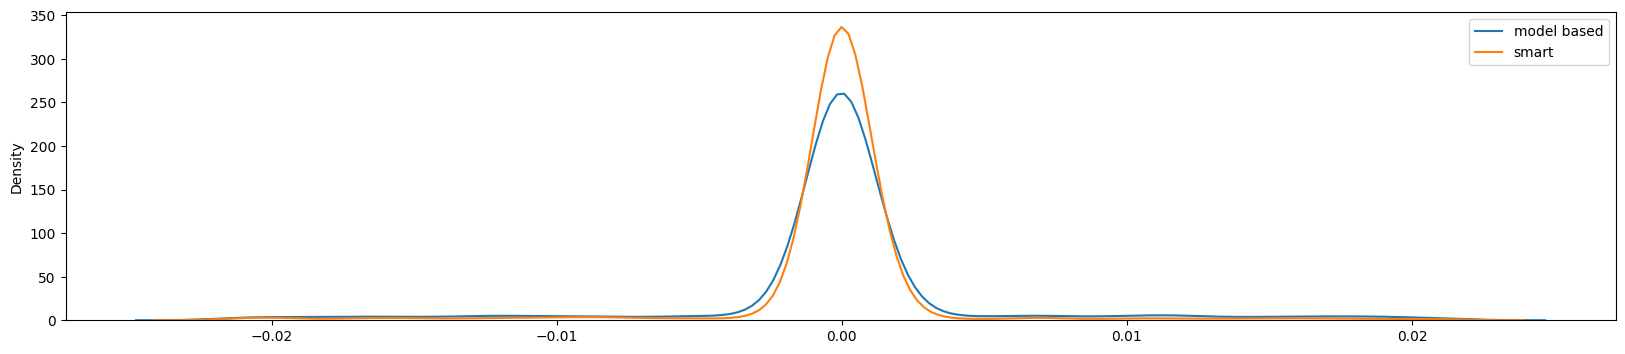

2023 7


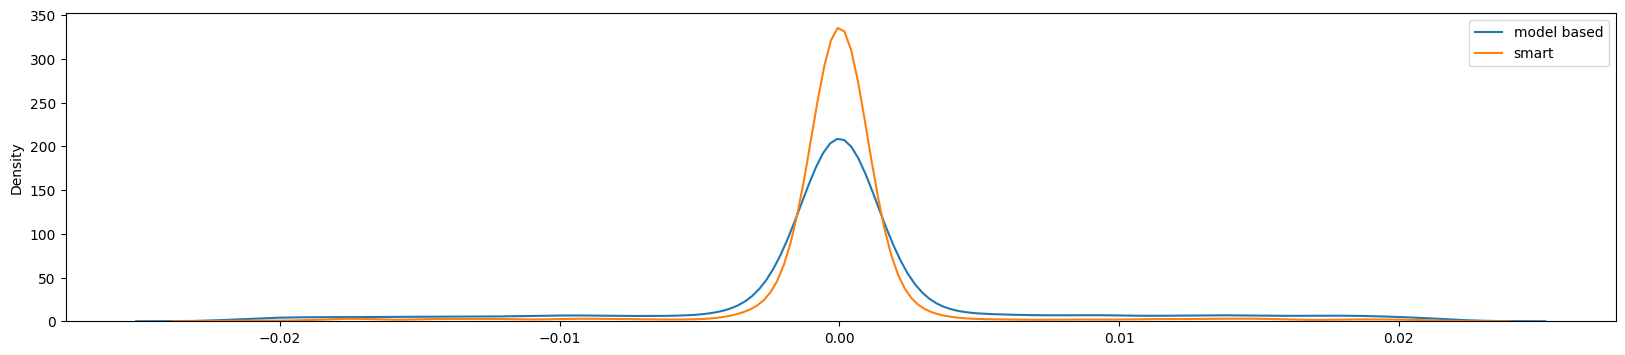

2023 8


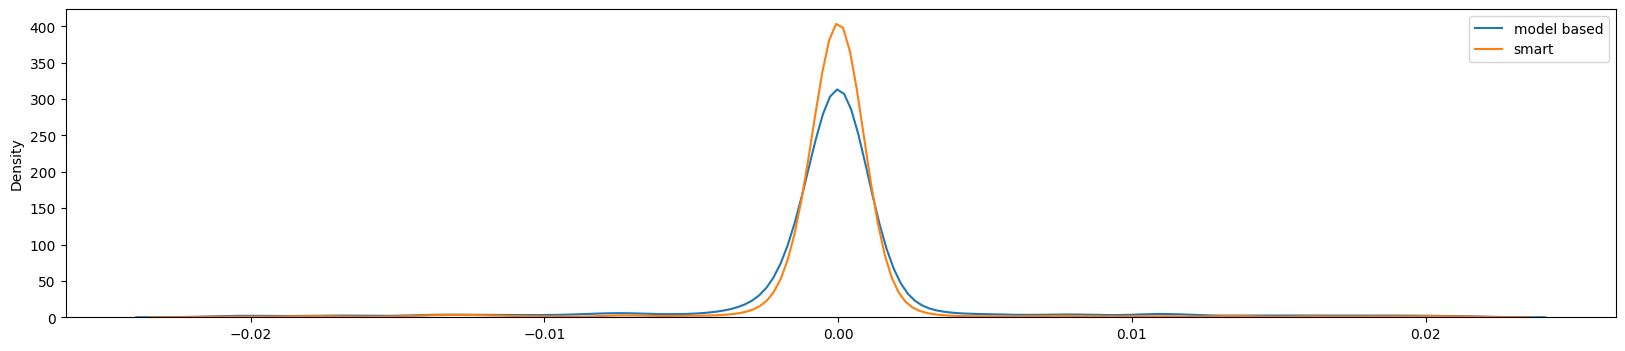

2023 9


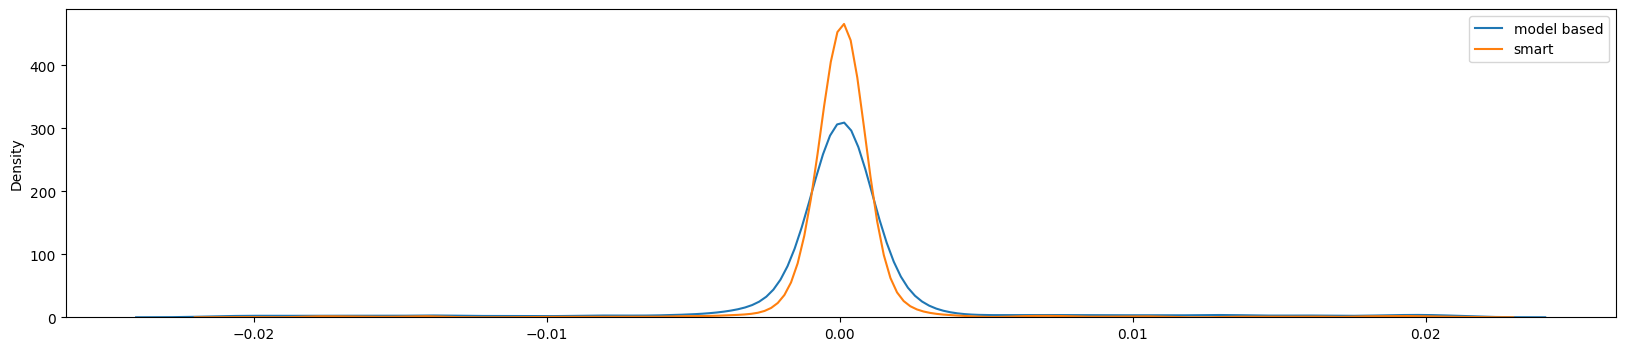

2023 10


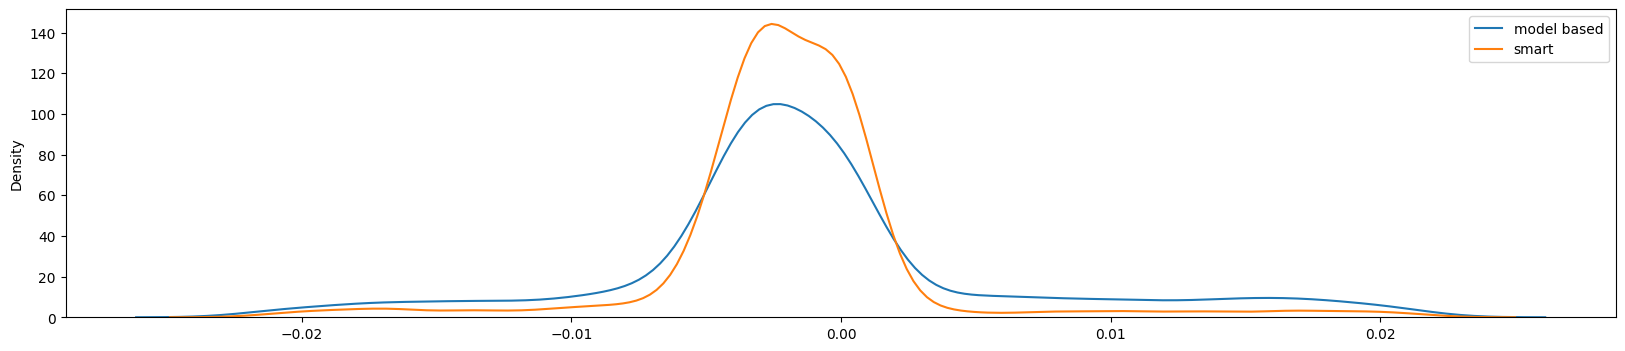

2023 11


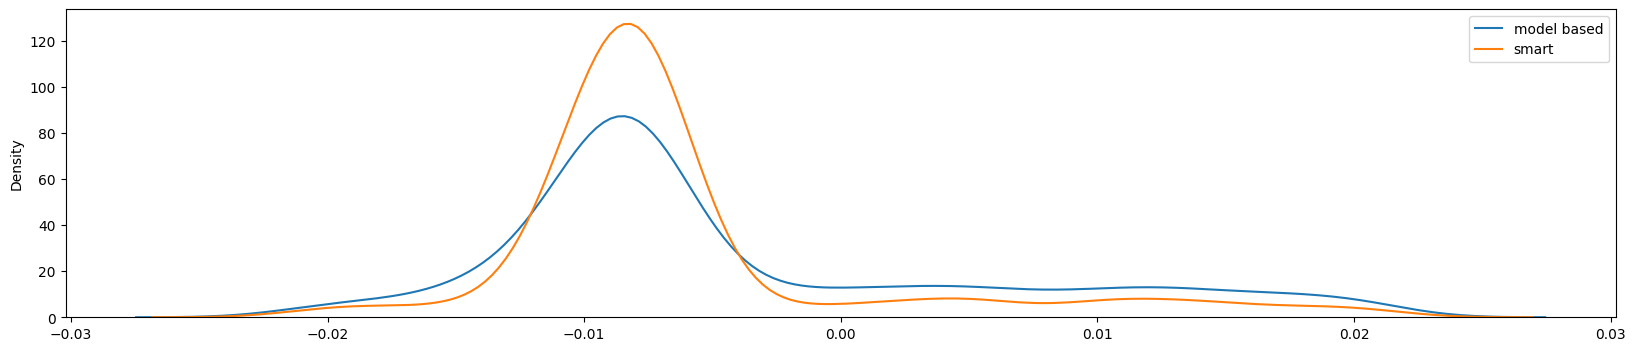

C:\Users\Max\AppData\Local\Temp\ipykernel_21248\1191317188.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(residual_model_based_tracked_year.loc[residual_model_based_tracked_year.index.month==month], label='model based')
C:\Users\Max\AppData\Local\Temp\ipykernel_21248\1191317188.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(residual_smart_tracked_year.loc[residual_smart_tracked_year.index.month==month], label='smart')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023 12


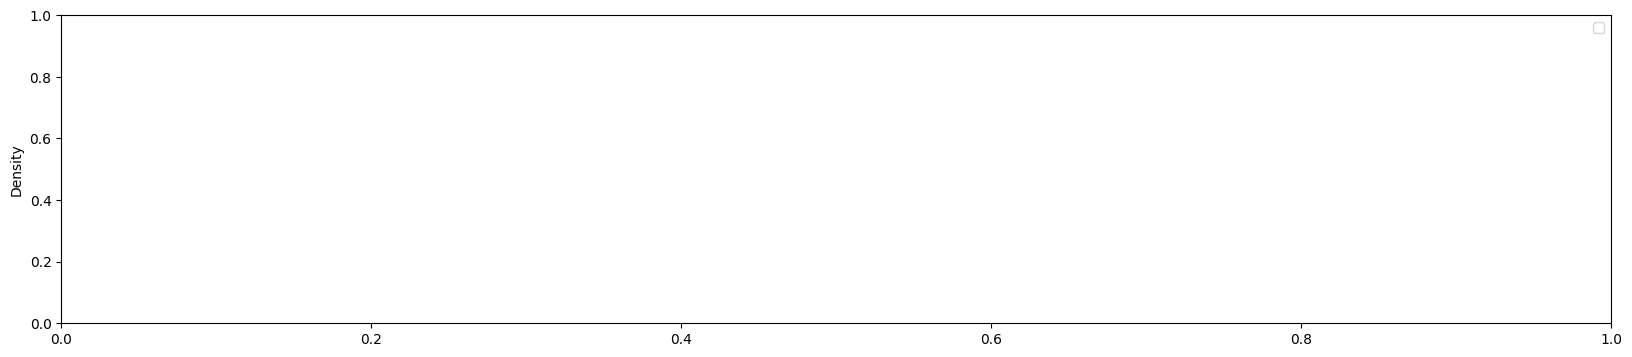

In [196]:
import seaborn as sns
for year in residual_smart_tracked.index.year.unique():
    indices_of_this_year_smart = residual_smart_tracked[residual_smart_tracked.index.year==year].index
    indices_of_this_year_model = residual_model_based_tracked[residual_model_based_tracked.index.year==year].index
    residual_model_based_tracked_year = residual_model_based_tracked.loc[indices_of_this_year_model]
    residual_smart_tracked_year = residual_smart_tracked.loc[indices_of_this_year_smart]
    for month in residual_smart_tracked_year.index.month.unique():
        plt.figure(figsize=(20, 4))
        print(year, month)
        sns.kdeplot(residual_model_based_tracked_year.loc[residual_model_based_tracked_year.index.month==month], label='model based')
        sns.kdeplot(residual_smart_tracked_year.loc[residual_smart_tracked_year.index.month==month], label='smart')
        plt.legend()
        plt.show()